In [1]:
# TP Allez plus loin dans la prédiction de loyer

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# On charge le dataset
house_data = pd.read_csv('house_data.csv')

# A-t-on des valeurs nulles ?
print(house_data[house_data.arrondissement.isnull() == True])
house_data.shape

     price  surface  arrondissement
149   3000      NaN             NaN
339    980      NaN             NaN
509   1590      NaN             NaN
674   1580      NaN             NaN
742    450      NaN             NaN


(827, 3)

In [2]:
# Un petit nettoyage s'impose pour les valeurs nulles
house_data = house_data[house_data.arrondissement.isnull() == False]
house_data.shape

(822, 3)

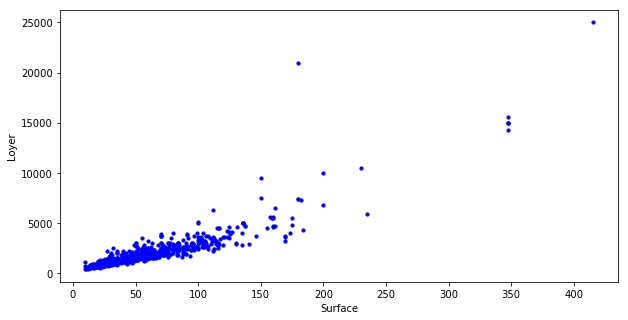

In [3]:
# Affichage avec la feature 'surface'
plt.figure(figsize=(10, 5))
plt.scatter(house_data.surface, house_data.price, s=10, color='blue')
plt.xlabel('Surface')
plt.ylabel('Loyer')
plt.show()

In [4]:
# L'affichage montre une régression linéaire, continuons avec une méthode qui va dans ce sens

# Profitons-en pour enlever deux valeurs manisfestement aberrantes qui risquent de brouiller nos métriques
house_data = house_data[house_data.price < 20000]

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = house_data.drop('price', axis=1)
y = house_data.price

# On fait une séparation training set, training test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# On gardera ces jeux de valeurs pour comparer les modèles

In [5]:
regr = LinearRegression()
regr.fit(xtrain[['surface']], ytrain)

# Les coefficients
print('Coefficients: ', regr.coef_)
# The root mean squared error
print("Erreur totale : %.2f" % np.sqrt(metrics.mean_squared_error(regr.predict(X[['surface']]), y)))
# Variance : 1 is perfect prediction
print('Variance : %.3f' % regr.score(xtest[['surface']], ytest))

Coefficients:  [ 34.61085935]
Erreur totale : 594.02
Variance : 0.818


In [6]:
# Maintenant on va tenter d'améliorer le modèle en utilisant les deux features
regr.fit(xtrain, ytrain)

# Les métriques :
print('Coefficients: ', regr.coef_)
print("Erreur totale : %.2f" % np.sqrt(metrics.mean_squared_error(regr.predict(X), y)))
print('Variance : %.3f' % regr.score(xtest, ytest))

# On va voir qu'effectivement les erreurs ont diminué et la variance a augmenté, ce test est meilleur

Coefficients:  [ 34.12513814 -53.39521962]
Erreur totale : 572.83
Variance : 0.822


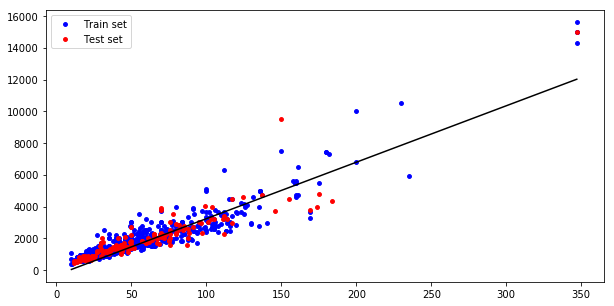

In [7]:
# Affichage du résultat de la régression linéaire avec 2 features
plt.figure(figsize=(10, 5))
plt.scatter(xtrain.surface, ytrain, color='blue', s=15, label='Train set')
plt.scatter(xtest.surface, ytest, color='red', s=15, label='Test set')
plt.plot([xtrain.surface.min(), xtrain.surface.max()], [regr.predict(xtrain).min(), regr.predict(xtrain).max()], color='black')
plt.legend()
plt.show()

In [8]:
# Le problème est que si on rejoue les modèles avec un nouveau jeu de test les résultats peuvent être assez différents
# Il faut donc faire attention à ça
# On peut essayer la regression linéaire sur plusieurs jeux de tests et rechercher le meilleur résultat
# La cross validation va nous permettre de faire ça

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(LinearRegression(), {}, cv=10, refit=True)
clf.fit(X, y)

# Les métriques :
print('Coefficients: ', clf.best_estimator_.coef_)
print("Erreur totale : %.2f" % np.sqrt(metrics.mean_squared_error(clf.best_estimator_.predict(X), y)))
print('Variance : %.3f' % clf.best_estimator_.score(xtest, ytest))

# C'est encore mieux !

Coefficients:  [ 33.74336848 -49.72702723]
Erreur totale : 572.35
Variance : 0.824


arrondissement=1 : 
   Erreur totale : 753.36
   Variance : 0.911
arrondissement=2 : 
   Erreur totale : 347.96
   Variance : 0.874
arrondissement=3 : 
   Erreur totale : 382.74
   Variance : 0.832
arrondissement=4 : 
   Erreur totale : 602.18
   Variance : 0.861
arrondissement=10 : 
   Erreur totale : 170.06
   Variance : 0.935


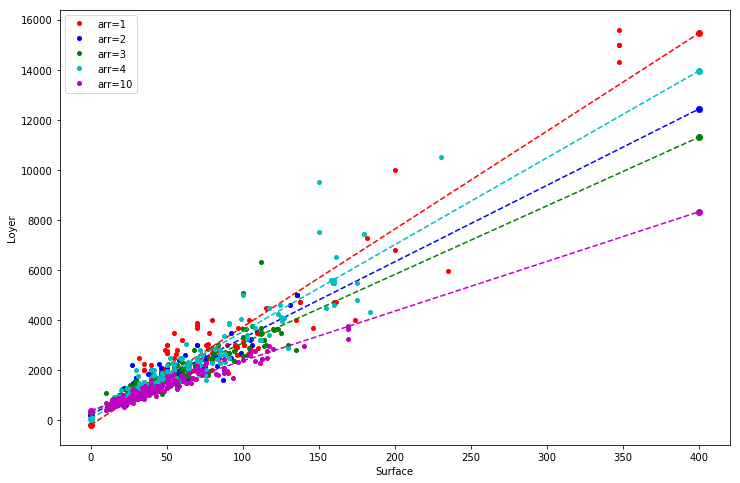

In [9]:
# Une autre méthode étant donné le nombre restreint d'arrondissment est de faire des régressions séparées,
# Une pour chaque arrondissment

plt.figure(figsize=(12, 8))
style = ['ro', 'bo', 'go', 'co', 'co', 'co', 'co', 'co', 'co', 'mo']

# On boucle sur la troisième feature
for i in range(1,11):
    dt = house_data[house_data.arrondissement==i]
    if (len(dt) > 0) :
        xi = dt[['surface']]
        yi = dt[['price']]

        regri = GridSearchCV(LinearRegression(), {}, cv=10, refit=True)
        regri.fit(xi, yi)
        best = regri.best_estimator_
        
        # Les métriques
        print('arrondissement=' + str(i) + ' : ')
        print("   Erreur totale : %.2f" % np.sqrt(metrics.mean_squared_error(best.predict(xi), yi)))
        print('   Variance : %.3f' % best.score(xi, yi))

        # Affichage
        plt.plot(xi, yi, style[i-1], markersize=4, label='arr=' + str(i))
        plt.plot([0, 400], [best.intercept_, best.intercept_ + 400 * best.coef_], style[i-1], linestyle='--')
plt.legend()
plt.xlabel('Surface')
plt.ylabel('Loyer')
plt.show()

In [ ]:
# Dans ce dernier cas les erreurs totales sont globalement meilleures
# En tout cas ça permet d'avoir une bien meilleure précision pour un arrondissement donné
# C'est donc ce modèle qu'il faut garder